In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import timedelta

In [2]:
path = r"C:\Self study\lớpDA\Momo\2022 Case challenge_ DA update.xlsx"
points = pd.read_excel(path, sheet_name='Data. Loyalty Points')
benefits = pd.read_excel(path, sheet_name='Data. Loyalty benefits')
transactions = pd.read_excel(path, sheet_name='Data. Transactions')
merchants = pd.read_excel(path, sheet_name='Data.Merchant')

In [3]:
points

,Service Group,Point Mechanism,Maximum Point Per Trans
0,supermarket,1 points/1000VND GMV,500 points
1,data,10 points/1000VND GMV,1000 points
2,cvs,1 points/1000VND GMV,300 points
3,marketplace,1 points/1000VND GMV,500 points
4,Coffee chains and Milk tea,1 points/1000VND GMV,500 points
5,Offline Beverage,1 points/1000VND GMV,300 points


In [4]:
benefits

,Class ID,Group,%cashback
0,2,cvs,5
1,2,Offline Beverage,5
2,2,data,5
3,3,cvs,7
4,3,Offline Beverage,7
5,3,data,7
6,3,marketplace,2
7,3,supermarket,2
8,4,cvs,12
9,4,Offline Beverage,12


In [5]:
transactions

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,Service Group
0,2021-01-01,8733622706,Marketplace,37,61386143,100000,marketplace
1,2021-01-01,8726857991,Supermarket,9,48453125,5000,supermarket
2,2021-01-01,8737326894,Supermarket,9,49921027,106600,supermarket
3,2021-01-01,8732579078,supermarket,9,46022523,270000,supermarket
4,2021-01-01,8725567343,CVS,8,44014594,68000,cvs
...,...,...,...,...,...,...,...
52755,2022-03-31,22531432792,Airtime,41,53272777,30000,data
52756,2022-03-31,22516959788,Airtime,41,41605249,10000,data
52757,2022-03-31,22518046622,Airtime,30,29029358,42000,data
52758,2022-03-31,22518047037,Airtime,30,29029358,5000,data


In [6]:
merchants

,ServiceID,Service Group,Merchant,MerchantID
0,7eleven,cvs,7eleven,1
1,MOMOIOQC20191008,cvs,7eleven,1
2,opcaeon,supermarket,Aeon Mall,2
3,MOMOGPCQ20190613,supermarket,Aeon Mall,2
4,MOMOONXG20191120,supermarket,Aeon Mall,2
...,...,...,...,...
213,buycard_data_vinaphone,data,Vinaphone,43
214,gift_buycard_data_vinaphone,data,Vinaphone,43
215,topup_data_vina,data,Vinaphone,43
216,waynescoffee,Coffee chains and Milk tea,Waynes Coffee,44


In [7]:
# Remove unnecessary columns: NEWVERTICAL_Merchant, MerchantID in transactions and Merchant in merchants
del transactions['NEWVERTICAL_Merchant'], transactions['MerchantID']

# Adjust the values in Maximum Point Per Trans to integer values
points['Maximum Point Per Trans'] = points['Maximum Point Per Trans'].str.replace(' points', '').astype(int)

# Change the DATE column to date type
transactions['DATE'] = pd.to_datetime(transactions['DATE'])

### Question 1:
Combined with the 'Loyalty Points' table, add a column 'Loyalty Points' in 'Transactions' table with given rules. Then create another table named 'Loyalty Ranking' which must includes columns named Rank_name and Calculated_points to calculate the Rank of each user on daily basic. At the end of Mar 2022, how many user achived rank Gold?


In [8]:
# Combine the 'Loyalty Points' table with the 'Transactions' table

merged_df = pd.merge(transactions, points, how='left', on='Service Group')

In [9]:
for index, row in merged_df.iterrows():
    points = row['Point Mechanism'].split("/")
    point_count = int(points[0].split(" ") [0])
    total = row['GMV'] / 1000 * point_count
    if total > row['Maximum Point Per Trans']:
        merged_df.at[index, 'Loyalty points'] = row['Maximum Point Per Trans']
    else:
        merged_df.at[index, 'Loyalty points'] = total

In [10]:
transactions['Loyalty points']  = merged_df ['Loyalty points'].copy().astype(int)

In [11]:
# Function to calculate Loyalty points within 30 days of [date]
def calculate_points_30d (date, user):
    user_transacts = transactions [transactions ['User_id'] == user]
    filter_upper = user_transacts['DATE'] <= date
    filter_lower = user_transacts['DATE'] >= (date - timedelta(days=30))
    transact_within_30_days = user_transacts[filter_upper & filter_lower]
    return transact_within_30_days ['Loyalty points'].sum()

# Function to rank customers:
def rank(in_30d_points):
    if in_30d_points >= 5000:
        return "DIAMOND"
    elif in_30d_points <= 4999 and in_30d_points >= 2000:
        return "GOLD"
    elif in_30d_points <= 1999 and in_30d_points >= 1000:
        return "SILVER"
    elif in_30d_points <= 999 and in_30d_points >= 1:
        return "STANDARD"

In [14]:
# Create copy of Transactions to process

transact_new = transactions.copy()
transact_new ['points within 30 days'] = 0

transact_new['points within 30 days'] = transact_new.apply(lambda row: calculate_points_30d(row['DATE'], row['User_id']), axis=1)
transact_new['Rank'] = transact_new['points within 30 days'].apply(rank)

In [15]:
transact_new

,DATE,Order_id,User_id,GMV,Service Group,Loyalty points,points within 30 days,Rank
0,2021-01-01,8733622706,61386143,100000,marketplace,100,100,STANDARD
1,2021-01-01,8726857991,48453125,5000,supermarket,5,5,STANDARD
2,2021-01-01,8737326894,49921027,106600,supermarket,106,106,STANDARD
3,2021-01-01,8732579078,46022523,270000,supermarket,270,270,STANDARD
4,2021-01-01,8725567343,44014594,68000,cvs,68,80,STANDARD
...,...,...,...,...,...,...,...,...
52755,2022-03-31,22531432792,53272777,30000,data,300,760,STANDARD
52756,2022-03-31,22516959788,41605249,10000,data,100,1916,SILVER
52757,2022-03-31,22518046622,29029358,42000,data,420,600,STANDARD
52758,2022-03-31,22518047037,29029358,5000,data,50,600,STANDARD


In [16]:
# Create table Loyalty Ranking

loyalty_ranking = transact_new [['DATE', 'User_id', 'GMV', 'Service Group', 'Rank', 'points within 30 days']].copy()
loyalty_ranking.rename(columns={'Rank': 'Rank_name','points within 30 days': 'Calculated_points'}, inplace=True)

# Define the lambda function to adjust ClassID based on Rank_name
loyalty_ranking['ClassID'] = loyalty_ranking['Rank_name'].apply(lambda x: 1 if x == 'STANDARD' else 2 if x == 'SILVER' else 3 if x == 'GOLD' else 4 if x == 'DIAMOND' else 0)
loyalty_ranking['ClassID'].astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
52755    1
52756    2
52757    1
52758    1
52759    1
Name: ClassID, Length: 52760, dtype: int32

In [17]:
loyalty_ranking

,DATE,User_id,GMV,Service Group,Rank_name,Calculated_points,ClassID
0,2021-01-01,61386143,100000,marketplace,STANDARD,100,1
1,2021-01-01,48453125,5000,supermarket,STANDARD,5,1
2,2021-01-01,49921027,106600,supermarket,STANDARD,106,1
3,2021-01-01,46022523,270000,supermarket,STANDARD,270,1
4,2021-01-01,44014594,68000,cvs,STANDARD,80,1
...,...,...,...,...,...,...,...
52755,2022-03-31,53272777,30000,data,STANDARD,760,1
52756,2022-03-31,41605249,10000,data,SILVER,1916,2
52757,2022-03-31,29029358,42000,data,STANDARD,600,1
52758,2022-03-31,29029358,5000,data,STANDARD,600,1


In [18]:
# Create ranking table to calculate points and rank customers on '2022-03-31'

transact_new['points within 30 days'] = transact_new.apply(lambda row: calculate_points_30d(pd.to_datetime('2022-03-31'), row['User_id']), axis=1)
transact_new['Rank'] = transact_new['points within 30 days'].apply(rank)

In [19]:
# Number of users achieved rank 'Gold' at the end of March 2022

golds = transact_new[ transact_new['Rank'] == 'GOLD' ].copy()
golds ['User_id'].nunique()

125

## Question 2

***Combined with the 'Loyalty benefits' table and 'Loyalty Ranking' table, add columns '%cashback'  in 'Transactions' table and calculate the total cashback cost in February 2022.***

In [20]:
benefits

,Class ID,Group,%cashback
0,2,cvs,5
1,2,Offline Beverage,5
2,2,data,5
3,3,cvs,7
4,3,Offline Beverage,7
5,3,data,7
6,3,marketplace,2
7,3,supermarket,2
8,4,cvs,12
9,4,Offline Beverage,12


In [21]:
merged_2 = pd.merge(loyalty_ranking, benefits, how='left', left_on=['ClassID', 'Service Group'], right_on=['Class ID', 'Group'])

In [22]:
del merged_2 ['Class ID'], merged_2 ['Group']

In [23]:
merged_2['cashback_cost'] = 0.0

for index, row in merged_2.iterrows():
    if pd.notna(row['%cashback']):
        cash = row['GMV'] * row['%cashback'] / 100
        if cash > 10000:
            merged_2.at[index, 'cashback_cost'] = 10000
        else:
            merged_2.at[index, 'cashback_cost'] = cash

In [24]:
# Total cashback cost in February 2022

feb_cash = merged_2[merged_2['DATE'].dt.month == 2]
feb_cash ['cashback_cost'] .sum()

4723241.74

***Conclude: The total cashback cost in February 2022 is 4,723,241.74 VND***

## Question 3: Retention Analysis

### 1. Daily Retention Analysis

In [25]:
df_date = transactions[['DATE', 'Order_id', 'User_id']].copy()

In [26]:
df_date

,DATE,Order_id,User_id
0,2021-01-01,8733622706,61386143
1,2021-01-01,8726857991,48453125
2,2021-01-01,8737326894,49921027
3,2021-01-01,8732579078,46022523
4,2021-01-01,8725567343,44014594
...,...,...,...
52755,2022-03-31,22531432792,53272777
52756,2022-03-31,22516959788,41605249
52757,2022-03-31,22518046622,29029358
52758,2022-03-31,22518047037,29029358


In [27]:
# Truncate week of the purchase date

def calculate_week(date, startdate):
    return ((date-startdate).days //7) +1 

df_date['Week'] = df_date['DATE'].apply(lambda x: calculate_week(x, df_date['DATE'].min()))

Text(0.5, 1.0, 'Number of Orders by Day of the Week')

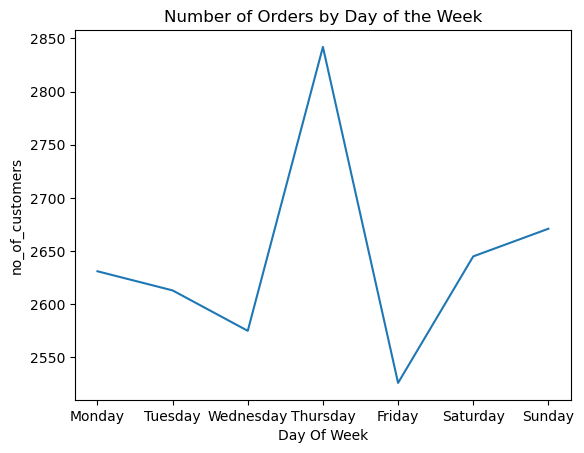

In [28]:
df_date['Day Of Week'] = df_date['DATE'].dt.day_name()
df_day = df_date.groupby(['Day Of Week']).agg(no_of_customers=('User_id', 'nunique')).reset_index(drop=False)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day['Day Of Week'] = pd.Categorical(df_day['Day Of Week'], categories=day_order, ordered=True)
sns.lineplot(x='Day Of Week', y= 'no_of_customers', data = df_day)
plt.title('Number of Orders by Day of the Week')

### 2. Weekly Retention Analysis

In [37]:
# Calculate weekly retention 

def calculate_weekly_retention(userid, date):
    user_transactions = transactions[transactions['User_id'] == userid]
    upper_filter = user_transactions['DATE'] < date
    lower_filter = user_transactions['DATE'] >= (date - timedelta(days=8))
    within_7d_transactions = user_transactions[upper_filter & lower_filter]
    if len(within_7d_transactions) >0: 
        return 1
    else:
        return 0
df_week = transact_new[['DATE', 'User_id','Order_id', 'Service Group', 'Rank']] .copy()
df_week['7 days Retention'] = df_week.apply(lambda row: calculate_weekly_retention(row['User_id'], row['DATE']), axis=1)


In [41]:
service = df_week.groupby('Service Group').agg({'Order_id':'count','7 days Retention':'sum'}).reset_index()
service['Ratio'] = service['7 days Retention'] / service['Order_id']
service = service.rename(columns={'7 days Retention': '7-day retention'})
service

,Service Group,Order_id,7-day retention,Ratio
0,Coffee chains and Milk tea,2279,1408,0.62
1,Offline Beverage,33,24,0.73
2,cvs,11685,8021,0.69
3,data,16090,7066,0.44
4,marketplace,17568,9875,0.56
5,supermarket,5105,3102,0.61


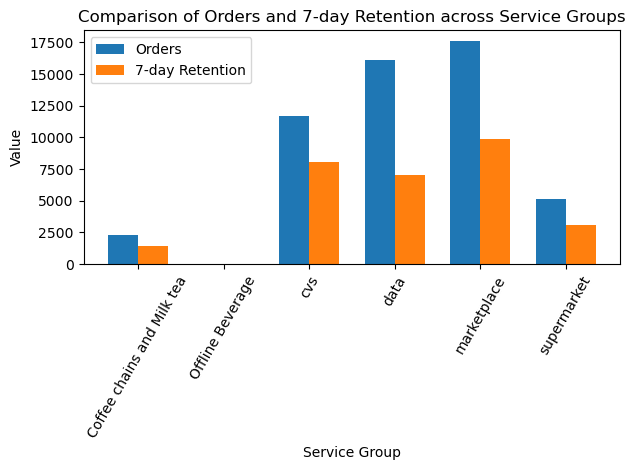

In [42]:
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(service['Service Group']))

# Plotting bars for Orders and 7-day Retention
ax.bar(index, service['Order_id'], bar_width, label='Orders')
ax.bar(index + bar_width, service['7-day retention'], bar_width, label='7-day Retention')

# Setting labels and title
ax.set_xlabel('Service Group')
ax.set_ylabel('Value')
ax.set_title('Comparison of Orders and 7-day Retention across Service Groups')

# Adjusting x-axis tick labels
plt.xticks(index + bar_width / 2, service['Service Group'], rotation = 60)

# Adding legend and adjusting layout
ax.legend()
plt.tight_layout()

# Displaying the plot
plt.show()

### Analysis of Orders and Retention by Service Groups:

- Offline Beverage stands out with the highest Retention/OrderID Ratio of 0.73, though both metrics are relatively low to draw significant conclusions
- CVS follows with a notable Retention/OrderID Ratio of 0.69, alongside a substantial number of orders (11,685)
- Marketplace and Data show high OrderID counts, but lower Ratios of 0.44 and 0.56, respectively.

### Recommendations:

- For CVS: prioritize increasing sales and transaction volume.
- For Marketplace and Data: concentrate efforts on improving retention rates.

In [44]:
ranknames = df_week.groupby('Rank').agg({'Order_id':'count','7 days Retention':'sum'}).reset_index()
ranknames['Ratio'] = ranknames['7 days Retention']/ ranknames['Order_id']
ranknames

,Rank,Order_id,7 days Retention,Ratio
0,DIAMOND,1858,1693,0.91
1,GOLD,6004,4718,0.79
2,SILVER,7855,5553,0.71
3,STANDARD,18453,10132,0.55


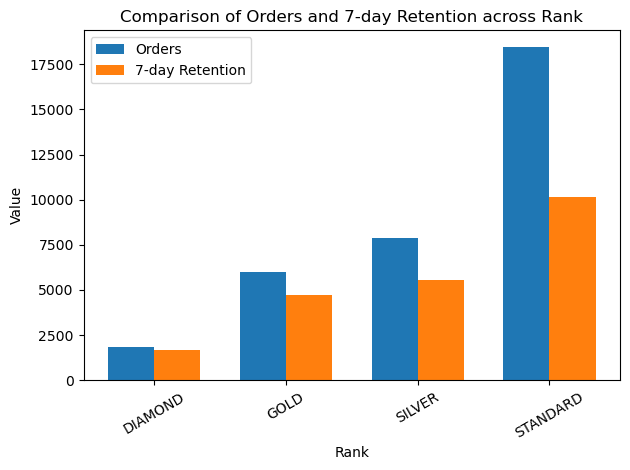

In [46]:
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(ranknames['Rank']))

# Plotting bars for Orders and 7-day Retention
ax.bar(index, ranknames['Order_id'], bar_width, label='Orders')
ax.bar(index + bar_width, ranknames['7 days Retention'], bar_width, label='7-day Retention')

# Setting labels and title
ax.set_xlabel('Rank')
ax.set_ylabel('Value')
ax.set_title('Comparison of Orders and 7-day Retention across Rank')

# Adjusting x-axis tick labels
plt.xticks(index + bar_width / 2, ranknames['Rank'], rotation=30)

# Adding legend and adjusting layout
ax.legend()
plt.tight_layout()

# Displaying the plot
plt.show()


### Analysis of Orders and Retention by Rank:
- Diamond customers exhibit the highest Retention/OrderID Ratio at 0.94.
- Standard customers show the lowest Retention/OrderID Ratio, measuring 0.42.
- The ratio increases progressively as customers move up through tiers: from Standard (0.42) to Silver (0.75), Gold (0.86), and finally Diamond (0.94).

### Recommendations:

- Prioritize efforts to elevate customers to higher tiers to enhance their loyalty.
- Devote exceptional customer service efforts to retain Silver, Gold, and Diamond tier customers effectively.

### 3. Monthly Cohort Analysis
### Analysis:
- The number of orders peaks on Thursday while bottoms on Wednesday and Friday
- ***Suggestion***: Launch promotion programs on Wednesday and Friday

In [47]:
df_date['Month'] =  df_date['DATE'].dt.to_period('M')

In [48]:
# Segment customers to their correct cohort based on the earliest transaction

df_date['Cohort'] = df_date.groupby('User_id')['DATE'].transform('min').dt.to_period('M')

In [49]:
# Create a table of number of customers per cohort per month

df_cohort = df_date.copy()
df_cohort = df_cohort.drop(columns=['Week'])
df_cohort = df_cohort.groupby(['Cohort', 'Month']).agg(no_of_customers=('User_id', 'nunique')).reset_index(drop=False)

In [50]:
df_cohort['Month_diff'] = (df_cohort['Month'] - df_cohort['Cohort']).apply(lambda x: x.n)

In [51]:
cohort_pivot = df_cohort.pivot_table(index='Cohort', columns='Month_diff', values='no_of_customers')

In [52]:
cohort_pivot

Month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Cohort,,,,,,,,,,,,,,,
2021-01,234.00,49.00,29.00,23.00,19.00,34.00,40.00,29.00,22.00,29.00,42.00,58.00,52.00,51.00,64.00
2021-02,199.00,21.00,9.00,11.00,17.00,32.00,31.00,24.00,28.00,34.00,37.00,35.00,39.00,41.00,NaN
2021-03,191.00,30.00,22.00,37.00,31.00,29.00,16.00,25.00,40.00,37.00,38.00,45.00,44.00,NaN,NaN
2021-04,155.00,38.00,39.00,30.00,24.00,22.00,25.00,27.00,33.00,28.00,35.00,32.00,NaN,NaN,NaN
2021-05,297.00,120.00,83.00,87.00,68.00,83.00,81.00,85.00,80.00,70.00,89.00,NaN,NaN,NaN,NaN
2021-06,702.00,236.00,199.00,162.00,192.00,207.00,213.00,203.00,193.00,218.00,NaN,NaN,NaN,NaN,NaN
2021-07,702.00,240.00,175.00,149.00,163.00,184.00,164.00,148.00,163.00,NaN,NaN,NaN,NaN,NaN,NaN
2021-08,794.00,240.00,199.00,184.00,225.00,186.00,185.00,195.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09,566.00,167.00,113.00,181.00,112.00,152.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
retention_rate = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)


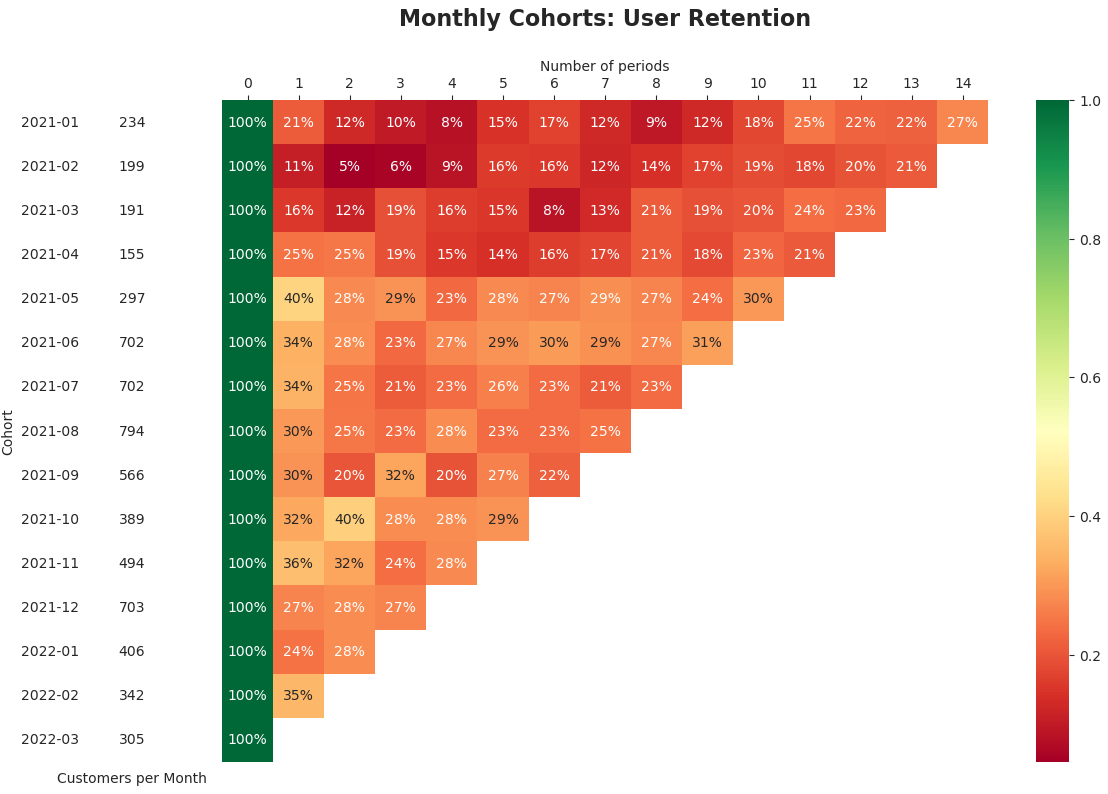

In [54]:
with sns.axes_style("white"):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    sns.heatmap(retention_rate, 
                    mask=retention_rate.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16, fontweight = 'bold', y= 1.1)
    ax[1].set(xlabel='Number of periods', ylabel='')
    ax[1].xaxis.set_ticks_position('top')
    ax[1].xaxis.set_label_position('top')

    cohort_size_df = pd.DataFrame(cohort_pivot.iloc[:, 0]).rename(columns={0: 'Customers per Month'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()


Text(0.5, 1.0, 'Number of Orders by Month')

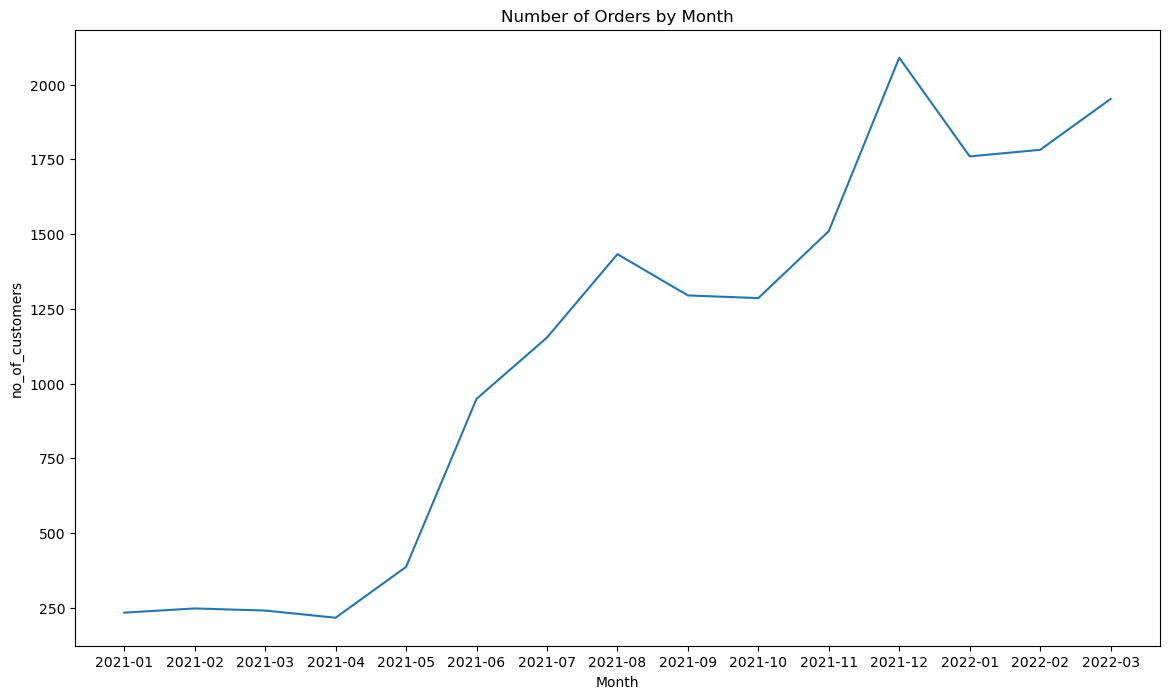

In [55]:
df_month = df_date.groupby(['Month']).agg(no_of_customers=('User_id', 'nunique')).reset_index(drop=False)
plt.figure(figsize=(14, 8))
sns.lineplot(x=df_month['Month'].astype(str), y= df_month['no_of_customers'])
plt.title('Number of Orders by Month')

### Cohort Analysis:
- Observing the top line, it can be easily seen that the retention rate was most stable between periods 5-7 (June - August 2021) and 11-14 (December 2021 - March 2022). If we look at the rows of these months, we can see that there was actually not much fluctuation in the retention rates.<br>
  &rarr; The program launched in these periods has proved successful
- Looking vertically, the transition from 1st to 2nd period always saw a sharp drop (noticeable by the great color contrast). Therefore, the crucial period for retaining customers is 1 month following their initial purchase.<br>
  &rarr; Need to look into and address this problem
- Looking diagonally down from 11th and 14th period (December 2021 and March 2022), retention rate was higher and more stable than average. Indeed, the line plot shows that the number of transactions peaks at those 2 months, which were around New Year, Christmas, and Lunar New Year. The bottom was in April (post Lunar New Year).<br>
  &rarr; Create "Urgency" discounts to take advantage of high demand during holiday seasons and start "Welcome Summer" promotions in April to boost sales

## Question 4: Cashback Analysis

Momo is facing increasing amount of cashback cost as well as  GMV since launched. However, we want to optimize the cost but still want to keep growth of GMV and increase the retention rate.  Based on data given, please propose ideas to change the schemes of Loyalty benefits and Loyalty Points to alleviate the cost amount.


In [56]:
cashback = merged_2 [['DATE','User_id', 'GMV', 'Service Group', 'cashback_cost']]
ranking = loyalty_ranking[['DATE', 'User_id','Rank_name']]
cashback_analysis = pd.merge(cashback, ranking, how='left', on= ('DATE', 'User_id'))

In [57]:
cashback_analysis

,DATE,User_id,GMV,Service Group,cashback_cost,Rank_name
0,2021-01-01,61386143,100000,marketplace,0.00,STANDARD
1,2021-01-01,48453125,5000,supermarket,0.00,STANDARD
2,2021-01-01,49921027,106600,supermarket,0.00,STANDARD
3,2021-01-01,46022523,270000,supermarket,0.00,STANDARD
4,2021-01-01,44014594,68000,cvs,0.00,STANDARD
...,...,...,...,...,...,...
126119,2022-03-31,29029358,42000,data,0.00,STANDARD
126120,2022-03-31,29029358,42000,data,0.00,STANDARD
126121,2022-03-31,29029358,5000,data,0.00,STANDARD
126122,2022-03-31,29029358,5000,data,0.00,STANDARD


In [58]:
cashback_ranks = cashback_analysis.groupby('Rank_name').agg({'GMV':'sum', 'cashback_cost':'sum'}).reset_index()
cashback_ranks['Ratio'] = cashback_ranks['cashback_cost'] / cashback_ranks['GMV']
cashback_ranks

,Rank_name,GMV,cashback_cost,Ratio
0,DIAMOND,12456261187,"238,672,015.18",0.02
1,GOLD,4285386637,"72,871,642.72",0.02
2,SILVER,3745284881,"21,354,521.70",0.01
3,STANDARD,4725742814,0.00,0.00


### Comments:

- Customers ranked 'Standard' did not receive cashback at all
- Customers ranked 'Diamond' and 'Gold' have equal cashback/GMV ratio

&rarr; We need to delve into which service group causes the most cashback costs in each rank section

### Gold Cashback

In [59]:
# Analyze Gold customers

gold_cashback = cashback_analysis[cashback_analysis['Rank_name']=='GOLD']
gold_cashback = gold_cashback.groupby('Service Group').agg({'GMV':'sum','cashback_cost':'sum'}).reset_index()
gold_cashback['Ratio'] = gold_cashback['cashback_cost'] / gold_cashback['GMV']
gold_cashback

,Service Group,GMV,cashback_cost,Ratio
0,Coffee chains and Milk tea,68995470,0.00,0.00
1,cvs,920023459,"16,860,274.06",0.02
2,data,109243000,"7,457,910.00",0.07
3,marketplace,2553550489,"39,514,215.24",0.02
4,supermarket,633574219,"9,039,243.42",0.01


### Diamond Cashback

In [60]:
# Analyze Diamond customers

diamond_cashback = cashback_analysis[cashback_analysis['Rank_name']=='DIAMOND']
diamond_cashback = diamond_cashback.groupby('Service Group').agg({'GMV':'sum','cashback_cost':'sum'}).reset_index()
diamond_cashback['Ratio'] = diamond_cashback['cashback_cost'] / diamond_cashback['GMV']
diamond_cashback

,Service Group,GMV,cashback_cost,Ratio
0,Coffee chains and Milk tea,41765973,0.00,0.00
1,cvs,624989394,"16,773,875.08",0.03
2,data,32908000,"3,306,200.00",0.10
3,marketplace,10365079766,"185,010,532.95",0.02
4,supermarket,1391518054,"33,581,407.15",0.02


### Standard Cashback

In [61]:
# Analyze Standard customers

standard_cashback = cashback_analysis[cashback_analysis['Rank_name']=='STANDARD']
standard_cashback = standard_cashback.groupby('Service Group').agg({'GMV':'sum','cashback_cost':'sum'}).reset_index()
standard_cashback['Ratio'] = standard_cashback['cashback_cost'] / standard_cashback['GMV']
standard_cashback

,Service Group,GMV,cashback_cost,Ratio
0,Coffee chains and Milk tea,159398212,0.00,0.00
1,Offline Beverage,2110000,0.00,0.00
2,cvs,1322285169,0.00,0.00
3,data,226920900,0.00,0.00
4,marketplace,2283101875,0.00,0.00
5,supermarket,731926658,0.00,0.00


In [62]:
# Analyze Silver customers

silver_cashback = cashback_analysis[cashback_analysis['Rank_name']=='SILVER']
silver_cashback = silver_cashback.groupby('Service Group').agg({'GMV':'sum','cashback_cost':'sum'}).reset_index()
silver_cashback['Ratio'] = silver_cashback['cashback_cost'] / silver_cashback['GMV']
silver_cashback

,Service Group,GMV,cashback_cost,Ratio
0,Coffee chains and Milk tea,63273915,0.00,0.00
1,Offline Beverage,1966000,"98,300.00",0.05
2,cvs,670336914,"14,620,551.70",0.02
3,data,132928400,"6,635,670.00",0.05
4,marketplace,2296120229,0.00,0.00
5,supermarket,580659423,0.00,0.00


In [63]:
standard_cashback.drop('Ratio',axis=1, inplace = True)
silver_cashback.drop('Ratio',axis=1, inplace=True)
gold_cashback.drop('Ratio',axis=1, inplace = True)
diamond_cashback.drop('Ratio',axis=1, inplace = True)

In [64]:
result_gmv = standard_cashback[['Service Group','GMV']].merge(silver_cashback[['Service Group','GMV']], on='Service Group', how='outer', suffixes=('_standard', '_silver'))
result_gmv = result_gmv.merge(gold_cashback[['Service Group','GMV']], on='Service Group', how='outer', suffixes=('_silver', '_gold'))
result_gmv = result_gmv.merge(diamond_cashback[['Service Group','GMV']], on='Service Group', how='outer', suffixes=('_gold', '_diamond'))

result_gmv.fillna(0, inplace=True)
result_gmv['GMV_standard'] = result_gmv['GMV_standard'].astype(float)
result_gmv['GMV_silver'] = result_gmv['GMV_silver'].astype(float)
result_gmv

,Service Group,GMV_standard,GMV_silver,GMV_gold,GMV_diamond
0,Coffee chains and Milk tea,"159,398,212.00","63,273,915.00","68,995,470.00","41,765,973.00"
1,Offline Beverage,"2,110,000.00","1,966,000.00",0.00,0.00
2,cvs,"1,322,285,169.00","670,336,914.00","920,023,459.00","624,989,394.00"
3,data,"226,920,900.00","132,928,400.00","109,243,000.00","32,908,000.00"
4,marketplace,"2,283,101,875.00","2,296,120,229.00","2,553,550,489.00","10,365,079,766.00"
5,supermarket,"731,926,658.00","580,659,423.00","633,574,219.00","1,391,518,054.00"


In [65]:
result_cashback = standard_cashback[['Service Group','cashback_cost']].merge(silver_cashback[['Service Group','cashback_cost']], on='Service Group', how='outer', suffixes=('_standard', '_silver'))
result_cashback = result_cashback.merge(gold_cashback[['Service Group','cashback_cost']], on='Service Group', how='outer', suffixes=('_silver', '_gold'))
result_cashback = result_cashback.merge(diamond_cashback[['Service Group','cashback_cost']], on='Service Group', how='outer', suffixes=('_gold', '_diamond'))

result_cashback.fillna(0, inplace=True)
result_cashback

,Service Group,cashback_cost_standard,cashback_cost_silver,cashback_cost_gold,cashback_cost_diamond
0,Coffee chains and Milk tea,0.00,0.00,0.00,0.00
1,Offline Beverage,0.00,"98,300.00",0.00,0.00
2,cvs,0.00,"14,620,551.70","16,860,274.06","16,773,875.08"
3,data,0.00,"6,635,670.00","7,457,910.00","3,306,200.00"
4,marketplace,0.00,0.00,"39,514,215.24","185,010,532.95"
5,supermarket,0.00,0.00,"9,039,243.42","33,581,407.15"


### Findings:
- The cashback cost for data services was high among all ranks (with cashback/GMV ratio between 0.7 and 0.10) while the retention rate was the lowest (0.44)<br>
    &rarr; Customers do not usually spend money on data services. We should lower the %cashback for data in all ranks<br>

- Customers ranked Standard accounted for most of the GMV, especially in CVS, but were the lowest retention rank (0.55) and received no cashbacks at all<br>
    &rarr; There should be %cashback program for CVS service and higher Loyalty Points for each transaction in other services to incentivize Standard customers to buy more frequently<br>

- Diamond and Gold groups had equal cashback/GMV ratio, with the cashback/GMV ratio largest within CVS and data sections. Diamond's cashback cost for CVS was approximate with Gold's cashback (around 16.7 millions VND) while Diamond's GMV was much lower (624,989,394 < 920,023,459)<br>
    &rarr; As CVS was the service with second highest retention rate (0.69), it can be implied that CVS is a necessity and inelastic to cashback changes. Therefore, the %cashback calculated for CVS should be lowered and cutoff points from Gold to Diamond should be higher<br>

- GMV was highest in marketplace<br>
    &rarr; There should be more Loyalty Points for each transaction for marketplace services.<br>



## Question 5

Gamification is usually a sensible option for apps to raise users’ stickiness. In our loyalty program development strategy, we also plan to hold a small game for users. The rule is simple: any users who can maintain a 20-day or longer streak of being in the DIAMOND ranking is a winner (in other words, winners are users who have total loyalty points greater than or equal to 5,000 for at least 20 consecutive days). We also want to give a special reward for the user(s) who can maintain the longest streak. Could you help us to calculate how many winners were there during the last thirty days in the given data (March 01 - March 31) and who was/were the one(s) boasting the longest streak during that time?		


In [66]:
# Find the transactions in March with Diamond rank

march = loyalty_ranking[ (loyalty_ranking['DATE'] >= '2022-03-01') & (loyalty_ranking['DATE'] <= '2022-03-31')]
march_diamond = march[(march['Rank_name'] == 'DIAMOND')] 
march_diamond

,DATE,User_id,GMV,Service Group,Rank_name,Calculated_points,ClassID
42474,2022-03-01,57207697,490000,marketplace,DIAMOND,5875,4
42478,2022-03-01,57207697,490000,marketplace,DIAMOND,5875,4
42499,2022-03-01,12229364,20000,data,DIAMOND,7848,4
42522,2022-03-01,47662326,180400,marketplace,DIAMOND,23565,4
42529,2022-03-01,57207697,20000,marketplace,DIAMOND,5875,4
...,...,...,...,...,...,...,...
52637,2022-03-31,44850195,150900,marketplace,DIAMOND,5712,4
52707,2022-03-31,49689927,10000,data,DIAMOND,9100,4
52732,2022-03-31,49689927,10000,data,DIAMOND,9100,4
52742,2022-03-31,49689927,10000,data,DIAMOND,9100,4


In [67]:
march_streak = march_diamond.groupby(['User_id']).agg(streak = ('DATE', lambda x: (x.max() - x.min()).days)).reset_index(drop=False)
march_streak

,User_id,streak
0,12229364,3
1,25993024,4
2,31244414,0
3,35461466,0
4,36884902,20
5,39314846,27
6,39619396,6
7,43160536,10
8,43933779,0
9,44119627,0


In [68]:
# Winners

march_streak[march_streak ['streak'] >= 20]

,User_id,streak
4,36884902,20
5,39314846,27
13,47662326,30
15,50185392,22
16,51432947,25
19,55200938,28
21,57207697,29


In [69]:
# Special Reward

march_streak[march_streak ['streak'] == march_streak ['streak'].max()]

,User_id,streak
13,47662326,30
